# Show HN: Who's Hiring for What Skills?

In [1048]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from collections import Counter
import json
from tqdm import tqdm
import re
import collections
import time
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

## Get comments

In [169]:
def get_comments(post_id: str):
    ''' returns comments of thread given post ID.
        Only base parents nodes, no comment children.
    '''
    req = requests.get(f'https://hacker-news.firebaseio.com/v0/item/{post_id}.json?print=pretty')
    return json.loads(req.text).get('kids',[])

In [170]:
def get_text(comment_id: str):
    req = requests.get(f'https://hacker-news.firebaseio.com/v0/item/{comment_id}.json?print=pretty')
    return json.loads(req.text).get('text','')

In [177]:
BAD_TOKENS = ('href','http','rel=')
def text_filter(text):
    tokens = re.sub('\W',' ',text).split()
    new_tokens = []
    for t in tokens:
        conditions = (any(x in t for x in BAD_TOKENS),
                     (len(t) <=1 and (t!='C' or t!='R')))
        if not any(conditions):
            new_tokens.append(t.lower().title())

    return new_tokens

In [518]:
# Most languages copies from:
# https://insights.stackoverflow.com/survey/2019

synonyms = ['Python','Python2','Python3','Gql','Graphql',
            'React','Reactjs','Node','Nodejs','Angularjs',
            'Angular','Vue','Vuejs','Java','J2ee','Mongo','Mongodb']

languages = synonyms + ['Javascript','Typescript','Coffeescript','Es6',
             'Erlang','Ida','C','C++','C#','Tableau',
             'Go','Golang','Elm','Elixir','Phoenix','Postgres','Postgresql',
             'Nextjs','Mean','Mern','Sql',
            'Rust','F#','Visualbasic','Html','Css','Bash','Ruby','Powershell','PHP',
            'Assembly','Swift','Objective','Scala','Kafka','Hadoop','Hdfs','Dart','Cockroachdb'
            'Clojure','Wasm','Webassembly','Kotlin','Jquery','Asp','Express','Spring',
            'Django','Flask','Laravel','Svelte','Drupal','Wordpress','Unity',
            'Tensorflow','Keras','Ansible','Spark','Unreal','Flutter','Pytorch','Puppet',
            'Chef','Cryengine','Mysql','Sqlite','Redis','Mariadb','Elasticsearch','Firebase',
            'Dynamodb','Cassandra','Couchbase','Docker','Kubernetes','R','Shiny','Jupyter']

## Test December

In [172]:
comments = get_comments('21683554')

In [194]:
COUNTS = Counter()

In [195]:
for comment_id in tqdm(comments):
    text = get_text(comment_id)
    text_filter(text)
    COUNTS.update(text_filter(text))


100%|██████████| 498/498 [04:53<00:00,  1.70it/s]


In [197]:
skills_df = pd.DataFrame(pd.Series(COUNTS))

In [204]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(skills_df[skills_df.index.isin(languages)])

,0
Java,57
Elasticsearch,16
Kafka,13
React,211
Javascript,69
Go,70
Typescript,53
Graphql,36
Docker,54
Kubernetes,56


# All Months 2019

In [217]:
months = collections.OrderedDict({
    "January" : 18807017,
    "February" : 19055166,
    "March" : 19281834,
    "April" : 19543940,
    "May" : 19797594,
    "June" : 20083795,
    "July" : 20325925,
    'August' : 20584311,
    'September' : 20867123,
    "October" : 21126014,
    "November" : 21419536,
    "December" : 21683554,
})

### Total comments

In [921]:
total = 0
for month,month_id in months.items():
    print(f'{month} - {len(get_comments(month_id))} job posts')
    total+=len(get_comments(month_id))

print('Total:',total)

January - 809 job posts
February - 735 job posts
March - 780 job posts
April - 791 job posts
May - 856 job posts
June - 697 job posts
July - 792 job posts
August - 755 job posts
September - 647 job posts
October - 760 job posts
November - 687 job posts
December - 576 job posts
Total: 8885


In [954]:
job_nums = pd.Series({
    "January":809,
    "February" :735 ,
    "March":780 ,
    "April" :791 ,
    "May" :856 ,
    "June" :697 ,
    "July" :792 ,
    "August" :755 ,
    "September" :647 ,
    "October" :760 ,
    "November" :687 ,
    "December" :576 
})
job_nums.mean()

740.4166666666666

### Scrape All
Don't run this multiple times or PG will throw a fit >:( 

Load the json `word_counts.json` instead

In [315]:
month_counts = {}
for month, month_id in tqdm(months.items()):
    counts = Counter()
    for comment_id in get_comments(month_id):
        text = get_text(comment_id)
        text_filter(text)
        counts.update(text_filter(text))
    month_counts[month] = counts

#### Save word counts just in case

In [1047]:
with open('word_counts.json','w') as f:
    json.dump(month_counts,f)

In [519]:
month_counts_df = pd.DataFrame(pd.Series(month_counts))

In [520]:
month_dfs = [[month,pd.DataFrame(pd.Series(month_counts[month]))] for month in month_counts.keys()]

In [521]:
for month in month_dfs:
    month[1] = month[1][month[1].index.isin(languages)].T
    month[1]['Month']=month[0]

In [522]:
language_counts_df = pd.concat([mdf[1] for mdf in month_dfs],sort=True)
language_counts_df.set_index('Month',inplace=True)
language_counts_df.fillna(0,inplace=True)

## Initial values

In [523]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(language_counts_df.head())

,Angular,Angularjs,Ansible,Asp,Assembly,Bash,Cassandra,Chef,Coffeescript,Couchbase,Css,Dart,Django,Docker,Drupal,Dynamodb,Elasticsearch,Elixir,Elm,Erlang,Es6,Express,Firebase,Flask,Flutter,Go,Golang,Graphql,Hadoop,Hdfs,Html,Ida,Java,Javascript,Jquery,Jupyter,Kafka,Keras,Kotlin,Kubernetes,Laravel,Mariadb,Mean,Mern,Mongo,Mongodb,Mysql,Nextjs,Node,Nodejs,Objective,Phoenix,Postgres,Postgresql,Powershell,Puppet,Python,Python3,Pytorch,React,Reactjs,Redis,Ruby,Rust,Scala,Shiny,Spark,Spring,Sql,Sqlite,Svelte,Swift,Tableau,Tensorflow,Typescript,Unity,Unreal,Vue,Vuejs,Wasm,Webassembly,Wordpress
Month,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
January,49,8,15,10.0,8,9,8,8,2.0,1.0,21,1.0,52,91,2.0,7,35,30,13.0,8,15.0,16,2.0,23,5.0,135,46,49,14,1.0,73,1.0,122,147,3,2.0,31,5,23,82,10,1.0,2.0,1.0,7,27,43,0.0,104,23,8,13,74,50,0.0,0.0,262,3.0,2,315,15,38,103,28,54,0.0,33,18,40,2,1.0,23,0.0,9,76,3,0.0,28,11,0.0,0.0,8.0
February,41,9,16,3.0,7,6,7,6,1.0,0.0,27,1.0,62,97,2.0,10,31,28,11.0,6,17.0,11,5.0,18,3.0,113,32,47,12,0.0,56,1.0,107,115,8,3.0,30,5,20,85,6,2.0,4.0,1.0,5,24,27,0.0,97,24,8,12,65,55,2.0,5.0,256,0.0,3,321,14,49,90,28,51,0.0,28,16,31,1,0.0,22,0.0,12,71,2,1.0,22,10,0.0,9.0,3.0
March,42,10,21,2.0,3,9,6,12,0.0,0.0,19,1.0,72,100,0.0,10,33,24,15.0,7,16.0,12,6.0,17,3.0,103,45,53,11,0.0,60,1.0,116,139,7,5.0,26,4,21,84,7,2.0,4.0,0.0,6,19,31,0.0,95,20,5,11,59,68,1.0,5.0,271,2.0,1,328,12,32,112,30,41,0.0,20,10,33,1,0.0,21,1.0,8,79,4,1.0,25,6,0.0,2.0,3.0
April,33,4,20,0.0,4,6,11,7,0.0,0.0,21,0.0,56,89,0.0,7,30,23,5.0,12,11.0,10,5.0,20,4.0,92,42,45,11,0.0,53,1.0,109,122,3,1.0,31,4,27,88,3,1.0,4.0,0.0,13,30,31,1.0,103,16,4,7,59,48,1.0,2.0,238,4.0,6,325,14,42,80,27,53,0.0,26,15,39,1,0.0,25,9.0,10,68,4,0.0,25,5,0.0,0.0,4.0
May,48,8,20,5.0,4,11,8,6,0.0,0.0,25,0.0,68,89,2.0,9,30,23,5.0,6,18.0,8,2.0,14,1.0,111,44,43,12,0.0,85,4.0,103,132,3,1.0,32,4,26,77,8,0.0,3.0,0.0,6,29,25,0.0,109,13,8,7,60,57,1.0,2.0,261,1.0,5,333,8,42,72,29,57,0.0,30,5,44,2,1.0,24,6.0,12,92,7,0.0,26,6,1.0,4.0,2.0


In [524]:
# Combine and delete synonyms
language_counts_df['Mongodb']+=language_counts_df['Mongo']
del language_counts_df['Mongo']
language_counts_df['Node']+=language_counts_df['Nodejs']
del language_counts_df['Nodejs']
language_counts_df['Python']+=language_counts_df['Python3']
del language_counts_df['Python3']
language_counts_df['Go']+=language_counts_df['Golang']
del language_counts_df['Golang']
language_counts_df['React']+=language_counts_df['Reactjs']
del language_counts_df['Reactjs']
language_counts_df['Vue']+=language_counts_df['Vuejs']
del language_counts_df['Vuejs']
language_counts_df['Angular']+=language_counts_df['Angularjs']
del language_counts_df['Angularjs']
language_counts_df['Javascript']+=language_counts_df['Es6']
del language_counts_df['Es6']

In [525]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(language_counts_df)

,Angular,Ansible,Asp,Assembly,Bash,Cassandra,Chef,Coffeescript,Couchbase,Css,Dart,Django,Docker,Drupal,Dynamodb,Elasticsearch,Elixir,Elm,Erlang,Express,Firebase,Flask,Flutter,Go,Graphql,Hadoop,Hdfs,Html,Ida,Java,Javascript,Jquery,Jupyter,Kafka,Keras,Kotlin,Kubernetes,Laravel,Mariadb,Mean,Mern,Mongodb,Mysql,Nextjs,Node,Objective,Phoenix,Postgres,Postgresql,Powershell,Puppet,Python,Pytorch,React,Redis,Ruby,Rust,Scala,Shiny,Spark,Spring,Sql,Sqlite,Svelte,Swift,Tableau,Tensorflow,Typescript,Unity,Unreal,Vue,Wasm,Webassembly,Wordpress
Month,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
January,57,15,10.0,8,9,8,8,2.0,1.0,21,1.0,52,91,2.0,7,35,30,13.0,8,16,2.0,23,5.0,181,49,14,1.0,73,1.0,122,162.0,3,2.0,31,5,23,82,10,1.0,2.0,1.0,34,43,0.0,127,8,13,74,50,0.0,0.0,265.0,2,330,38,103,28,54,0.0,33,18,40,2,1.0,23,0.0,9,76,3,0.0,39,0.0,0.0,8.0
February,50,16,3.0,7,6,7,6,1.0,0.0,27,1.0,62,97,2.0,10,31,28,11.0,6,11,5.0,18,3.0,145,47,12,0.0,56,1.0,107,132.0,8,3.0,30,5,20,85,6,2.0,4.0,1.0,29,27,0.0,121,8,12,65,55,2.0,5.0,256.0,3,335,49,90,28,51,0.0,28,16,31,1,0.0,22,0.0,12,71,2,1.0,32,0.0,9.0,3.0
March,52,21,2.0,3,9,6,12,0.0,0.0,19,1.0,72,100,0.0,10,33,24,15.0,7,12,6.0,17,3.0,148,53,11,0.0,60,1.0,116,155.0,7,5.0,26,4,21,84,7,2.0,4.0,0.0,25,31,0.0,115,5,11,59,68,1.0,5.0,273.0,1,340,32,112,30,41,0.0,20,10,33,1,0.0,21,1.0,8,79,4,1.0,31,0.0,2.0,3.0
April,37,20,0.0,4,6,11,7,0.0,0.0,21,0.0,56,89,0.0,7,30,23,5.0,12,10,5.0,20,4.0,134,45,11,0.0,53,1.0,109,133.0,3,1.0,31,4,27,88,3,1.0,4.0,0.0,43,31,1.0,119,4,7,59,48,1.0,2.0,242.0,6,339,42,80,27,53,0.0,26,15,39,1,0.0,25,9.0,10,68,4,0.0,30,0.0,0.0,4.0
May,56,20,5.0,4,11,8,6,0.0,0.0,25,0.0,68,89,2.0,9,30,23,5.0,6,8,2.0,14,1.0,155,43,12,0.0,85,4.0,103,150.0,3,1.0,32,4,26,77,8,0.0,3.0,0.0,35,25,0.0,122,8,7,60,57,1.0,2.0,262.0,5,341,42,72,29,57,0.0,30,5,44,2,1.0,24,6.0,12,92,7,0.0,32,1.0,4.0,2.0
June,55,11,7.0,2,6,5,4,2.0,0.0,23,0.0,58,68,0.0,4,28,27,2.0,8,10,0.0,17,0.0,130,40,6,0.0,60,1.0,94,136.0,9,2.0,19,3,15,61,2,0.0,5.0,0.0,21,26,2.0,88,7,8,54,43,2.0,3.0,225.0,4,288,33,82,33,59,1.0,12,11,42,3,0.0,26,1.0,7,68,9,0.0,28,0.0,1.0,3.0
July,49,19,6.0,7,11,12,5,3.0,1.0,20,2.0,54,74,1.0,8,33,24,4.0,5,9,3.0,22,4.0,170,43,8,1.0,67,1.0,118,147.0,7,2.0,26,4,27,71,9,1.0,5.0,1.0,25,38,1.0,117,7,5,56,47,1.0,3.0,258.0,3,338,46,106,36,48,1.0,21,12,33,5,0.0,33,4.0,11,77,3,0.0,34,0.0,4.0,7.0
August,43,21,3.0,6,11,6,8,2.0,0.0,24,0.0,51,80,1.0,11,34,22,1.0,9,10,4.0,14,4.0,126,41,13,0.0,76,1.0,89,140.0,6,0.0,23,4,29,85,8,1.0,1.0,0.0,28,24,1.0,113,10,5,57,47,3.0,4.0,237.0,5,365,39,78,32,42,1.0,24,11,31,2,0.0,24,1.0,11,95,5,0.0,26,0.0,4.0,2.0
September,48,22,4.0,3,9,5,5,1.0,0.0,16,2.0,43,81,0.0,5,15,24,0.0,4,11,1.0,10,1.0,112,43,6,0.0,49,0.0,93,116.0,4,2.0,23,3,26,78,4,0.0,2.0,0.0,29,24,1.0,122,5,8,58,44,2.0,3.0,209.0,3,346,32,74,36,28,0.0,20,12,33,2,0.0,15,3.0,5,105,4,1.0,25,1.0,5.0,0.0


In [1041]:
language_counts_df.to_csv('skill_data.csv')

# Top N languages 
## Pie

In [1034]:
N_VALS = 19
language_avgs = language_counts_df.sum().sort_values(ascending=False)[:N_VALS]
language_avgs.loc['Other'] = sum(language_counts_df.sum().sort_values(ascending=False)[N_VALS:])

In [1035]:
sum(language_counts_df.sum().sort_values(ascending=False))

27666.0

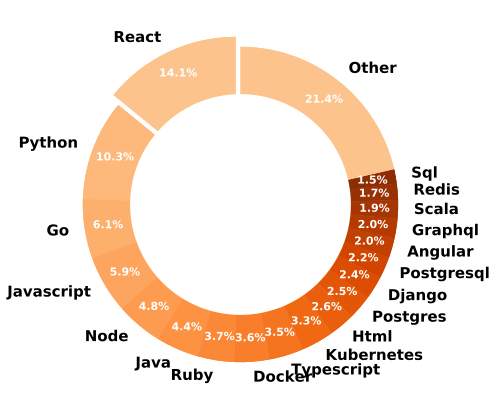

In [1039]:
plt.figure(figsize=(7,7))

#colors
colors = plt.cm.Oranges(np.linspace(0.3, 0.95, N_VALS))

#labels

labels = language_avgs.index

#explosion
explode = [0.0 for n in range(N_VALS+1)]
explode[0] = 0.07
 
# Draw 2 plots so the font can change
# Names
plt.pie(language_avgs, 
        startangle=90, 
        colors = colors,
        pctdistance=0.85, 
        labels=labels,
        explode=explode,
        textprops={'fontweight': 'bold', 'fontsize':15})

# Percentages
plt.pie(language_avgs, autopct='%1.1f%%', 
        startangle=90, 
        colors = colors,
        pctdistance=0.85, 
        explode=explode,
       textprops={'fontweight': 'bold','color':'white',
                  'fontsize':11})



#draw circle
center_circle = plt.Circle((0,0),0.70,fc='white')

fig = plt.gcf()
fig.gca().add_artist(center_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.tight_layout()

plt.savefig('pie.svg',format='svg')
plt.show()


## Bar chart

In [748]:
hn_orange = (.94,.44,.18)

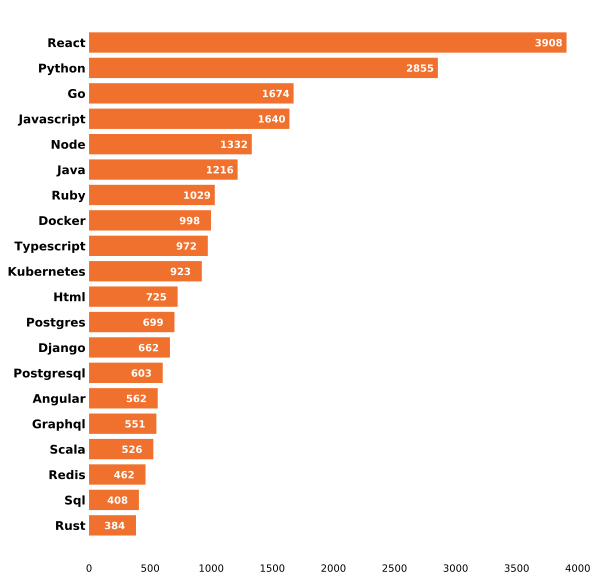

In [916]:
fig, ax = plt.subplots(1,1, figsize=(9,10))
fig.patch.set_visible(False)
# get rid of the frame
for spine in plt.gca().spines.values():
    spine.set_visible(False)

n=20
top_n = language_counts_df.sum().sort_values(ascending=False)[:n]

barchart = plt.barh(y=top_n.index[::-1],
        width=top_n[::-1],
        color=hn_orange,
        )

# tick params
# Remove dashes
ax.tick_params(axis=u'both', which=u'both',length=0)
# Set ticks
plt.yticks(fontsize = 12, fontweight="bold") 

for i, v in enumerate(top_n[::-1]):
    ax.text(v-260, i-0.15, str(int(v)), color='white',fontsize=10, fontweight='bold')
plt.savefig('bars.svg',format='svg')
plt.show()


## Over time 

In [932]:
n=7
top_n = language_counts_df.sum().sort_values(ascending=False)[:n]

In [933]:
top_n_2019 = language_counts_df[top_n.index].drop('December')
top_n_2019

,React,Python,Go,Javascript,Node,Java,Ruby
Month,,,,,,,
January,330,265.0,181,162.0,127,122,103
February,335,256.0,145,132.0,121,107,90
March,340,273.0,148,155.0,115,116,112
April,339,242.0,134,133.0,119,109,80
May,341,262.0,155,150.0,122,103,72
June,288,225.0,130,136.0,88,94,82
July,338,258.0,170,147.0,117,118,106
August,365,237.0,126,140.0,113,89,78
September,346,209.0,112,116.0,122,93,74


<Figure size 640x480 with 0 Axes>

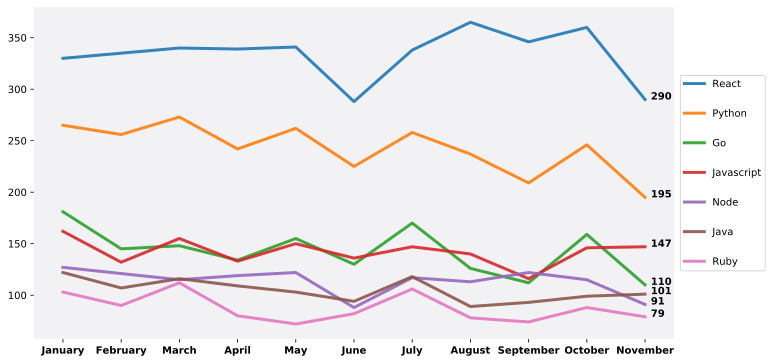

In [934]:
plt.figure()
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

fig, ax = plt.subplots(1,1, figsize=(11.5,6))
ax.set_facecolor((.95,.95,.960))

# fig.patch.set_visible(False)

# get rid of the frame
for spine in plt.gca().spines.values():
    spine.set_visible(False)
    
    
# language_counts_df[top_n.index].plot()

num=0
for ndx, column in enumerate(top_n_2019):
    num+=1
    plt.plot(top_n_2019.index,
             top_n_2019[column],
             marker='', linewidth=3,
             alpha=0.9, label=column,
             )
     
for val, m in zip(top_n_2019.loc['November'],top_n_2019.columns):
    name=m
    plt.text(10.1, val, int(val),
             horizontalalignment='left', 
             fontweight="bold"
            )
plt.xticks(fontweight='bold',)
plt.legend(loc='right',bbox_to_anchor=(1.15, 0.5), labelspacing=2)
plt.savefig('lines.svg',format='svg')
plt.show()


In [928]:
top_n_2019

,Svelte,Wasm,Couchbase,Mern,Shiny,Unreal,Hdfs,Nextjs,Mariadb,Dart,...,Flutter,Pytorch,Wordpress,Keras,Puppet,Asp,Unity,Elm,Assembly,Jquery
Month,,,,,,,,,,,,,,,,,,,,,
January,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,...,5.0,2,8.0,5,0.0,10.0,3,13.0,8,3
February,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,1.0,...,3.0,3,3.0,5,5.0,3.0,2,11.0,7,8
March,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,...,3.0,1,3.0,4,5.0,2.0,4,15.0,3,7
April,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,4.0,6,4.0,4,2.0,0.0,4,5.0,4,3
May,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,5,2.0,4,2.0,5.0,7,5.0,4,3
June,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,...,0.0,4,3.0,3,3.0,7.0,9,2.0,2,9
July,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,2.0,...,4.0,3,7.0,4,3.0,6.0,3,4.0,7,7
August,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,4.0,5,2.0,4,4.0,3.0,5,1.0,6,6
September,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,...,1.0,3,0.0,3,3.0,4.0,4,0.0,3,4


In [939]:
for l in sorted(languages):
    print(l,end=', ')

Angular, Angularjs, Ansible, Asp, Assembly, Bash, C, C#, C++, Cassandra, Chef, CockroachdbClojure, Coffeescript, Couchbase, Cryengine, Css, Dart, Django, Docker, Drupal, Dynamodb, Elasticsearch, Elixir, Elm, Erlang, Es6, Express, F#, Firebase, Flask, Flutter, Go, Golang, Gql, Graphql, Hadoop, Hdfs, Html, Ida, J2ee, Java, Javascript, Jquery, Jupyter, Kafka, Keras, Kotlin, Kubernetes, Laravel, Mariadb, Mean, Mern, Mongo, Mongodb, Mysql, Nextjs, Node, Nodejs, Objective, PHP, Phoenix, Postgres, Postgresql, Powershell, Puppet, Python, Python2, Python3, Pytorch, R, React, Reactjs, Redis, Ruby, Rust, Scala, Shiny, Spark, Spring, Sql, Sqlite, Svelte, Swift, Tableau, Tensorflow, Typescript, Unity, Unreal, Visualbasic, Vue, Vuejs, Wasm, Webassembly, Wordpress, 

In [960]:
len(languages)

94